In [ ]:
!pip install --upgrade tensorflow

!pip install Box2D

!sudo apt-get install -y xvfb ffmpeg
!pip install 'gym==0.10.11'
!pip install 'imageio==2.4.0'
!pip install PILLOW
!pip install 'pyglet==1.3.2'
!pip install pyvirtualdisplay
!pip install --upgrade tensorflow-probability
!pip install tf-agents
!pip install tf-agents[reverb]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 588.3 MB 20 kB/s 
     |████████████████████████████████| 1.7 MB 42.7 MB/s 
     |████████████████████████████████| 439 kB 46.6 MB/s 
     |████████████████████████████████| 6.0 MB 45.5 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully u

In [ ]:
import tensorflow as tf
import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import reverb

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common
from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.networks import categorical_q_network

from tf_agents.specs import tensor_spec
from tf_agents.trajectories import time_step as ts

In [ ]:
from tf_agents.environments import suite_gym

In [ ]:
env = suite_gym.load("LunarLander-v2")

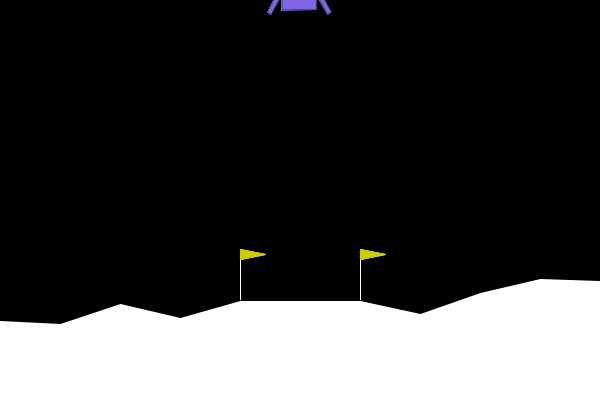

In [ ]:
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

env.reset()
PIL.Image.fromarray(env.render())

In [ ]:
from tf_agents.environments.tf_py_environment import TFPyEnvironment
tf_env = TFPyEnvironment(env)

In [ ]:
print('Observation Spec:')
print(env.time_step_spec().observation)

Observation Spec:
BoundedArraySpec(shape=(8,), dtype=dtype('float32'), name='observation', minimum=-3.4028234663852886e+38, maximum=3.4028234663852886e+38)


In [ ]:
print('Action Spec:')
print(env.action_spec())

Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=3)


In [ ]:
from tf_agents.networks.q_network import QNetwork

fc_layer_params = [512,256]

q_net = QNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),

    fc_layer_params=fc_layer_params
)

In [ ]:
from tf_agents.agents.dqn.dqn_agent import DqnAgent

In [ ]:
from tensorflow import keras
from keras.backend import learning_phase
from keras.backend_config import epsilon
train_step = tf.Variable(0)
update_period = 4 

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate = 1e-3 )

epsilon_fn = keras.optimizers.schedules.PolynomialDecay(initial_learning_rate = 0.07, decay_steps = 250000 // update_period,end_learning_rate = 0.001)

agent = DqnAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    q_network = q_net,
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate = 1e-3),
    td_errors_loss_fn=common.element_wise_squared_loss,
    gamma = 0.99,
    train_step_counter=train_step,
    epsilon_greedy = lambda: epsilon_fn(train_step)
)

agent.initialize()

In [ ]:
from tf_agents.replay_buffers import tf_uniform_replay_buffer
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec = agent.collect_data_spec,
    batch_size = tf_env.batch_size,
    max_length= 2000
)

In [ ]:
replay_buffer_observer = replay_buffer.add_batch

In [ ]:
from tf_agents.metrics import tf_metrics

train_metrics = [
    tf_metrics.NumberOfEpisodes(),
    tf_metrics.EnvironmentSteps(),
    tf_metrics.AverageReturnMetric(),
    tf_metrics.AverageEpisodeLengthMetric(),
]


In [ ]:
from tf_agents.eval.metric_utils import log_metrics
import logging
logging.getLogger().setLevel(logging.INFO)
log_metrics(train_metrics)

INFO:absl: 
		 NumberOfEpisodes = 0
		 EnvironmentSteps = 0
		 AverageReturn = 0.0
		 AverageEpisodeLength = 0.0


In [ ]:
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver

collect_driver = DynamicStepDriver(
    tf_env,
    agent.collect_policy,
    observers = [replay_buffer_observer] + train_metrics,
    num_steps = update_period
)

In [ ]:
from tf_agents.policies.random_tf_policy import RandomTFPolicy

class ShowProgress:
  def __init__(self, total):
    self.counter = 0
    self.total = total
  def __call__(self, trajectory):
    if not trajectory.is_boundary():
      self.counter += 1
    if self.counter % 1000 == 0:
      print("\r{}/{}".format(self.counter, self.total), end="")

In [ ]:
initial_collect_policy = RandomTFPolicy(tf_env.time_step_spec(),tf_env.action_spec())

init_driver = DynamicStepDriver(tf_env,initial_collect_policy,
                                observers=[replay_buffer.add_batch, ShowProgress(1000)],
                                num_steps=1000)

final_time_step,final_policy_state = init_driver.run()

1000/1000

In [ ]:
dataset = replay_buffer.as_dataset(sample_batch_size = 64,
                                   num_steps = 2,
                                   num_parallel_calls=3).prefetch(3)

In [ ]:
def agent_train(n_iterations):
  time_step = None
  policy_state = agent. collect_policy.get_initial_state (tf_env.batch_size)
  iterator = iter (dataset)
  for iteration in range (n_iterations):
    time_step, policy_state = collect_driver.run(time_step, policy_state)
    trajectories, buffer_info = next (iterator)
    train_loss = agent.train(trajectories)
    print("\r{} loss:{:.5f}".format(
        iteration, train_loss.loss.numpy()
    ),end="")

    if iteration & 1000 == 0:
      log_metrics(train_metrics)

In [ ]:
agent_train(10000)

INFO:absl: 
		 NumberOfEpisodes = 27
		 EnvironmentSteps = 16165
		 AverageReturn = -92.6151351928711
		 AverageEpisodeLength = 708.5
INFO:absl: 
		 NumberOfEpisodes = 27
		 EnvironmentSteps = 16169
		 AverageReturn = -92.6151351928711
		 AverageEpisodeLength = 708.5


1 loss:0.78589

INFO:absl: 
		 NumberOfEpisodes = 27
		 EnvironmentSteps = 16173
		 AverageReturn = -92.6151351928711
		 AverageEpisodeLength = 708.5
INFO:absl: 
		 NumberOfEpisodes = 27
		 EnvironmentSteps = 16177
		 AverageReturn = -92.6151351928711
		 AverageEpisodeLength = 708.5


3 loss:1.07372

INFO:absl: 
		 NumberOfEpisodes = 27
		 EnvironmentSteps = 16181
		 AverageReturn = -92.6151351928711
		 AverageEpisodeLength = 708.5
INFO:absl: 
		 NumberOfEpisodes = 27
		 EnvironmentSteps = 16185
		 AverageReturn = -92.6151351928711
		 AverageEpisodeLength = 708.5


5 loss:0.88630

INFO:absl: 
		 NumberOfEpisodes = 27
		 EnvironmentSteps = 16189
		 AverageReturn = -92.6151351928711
		 AverageEpisodeLength = 708.5
INFO:absl: 
		 NumberOfEpisodes = 27
		 EnvironmentSteps = 16193
		 AverageReturn = -92.6151351928711
		 AverageEpisodeLength = 708.5


15 loss:0.56667

INFO:absl: 
		 NumberOfEpisodes = 27
		 EnvironmentSteps = 16229
		 AverageReturn = -92.6151351928711
		 AverageEpisodeLength = 708.5
INFO:absl: 
		 NumberOfEpisodes = 27
		 EnvironmentSteps = 16233
		 AverageReturn = -92.6151351928711
		 AverageEpisodeLength = 708.5


17 loss:0.76072

INFO:absl: 
		 NumberOfEpisodes = 27
		 EnvironmentSteps = 16237
		 AverageReturn = -92.6151351928711
		 AverageEpisodeLength = 708.5
INFO:absl: 
		 NumberOfEpisodes = 27
		 EnvironmentSteps = 16241
		 AverageReturn = -92.6151351928711
		 AverageEpisodeLength = 708.5


19 loss:0.74529

INFO:absl: 
		 NumberOfEpisodes = 27
		 EnvironmentSteps = 16245
		 AverageReturn = -92.6151351928711
		 AverageEpisodeLength = 708.5
INFO:absl: 
		 NumberOfEpisodes = 27
		 EnvironmentSteps = 16249
		 AverageReturn = -92.6151351928711
		 AverageEpisodeLength = 708.5


21 loss:0.61775

INFO:absl: 
		 NumberOfEpisodes = 27
		 EnvironmentSteps = 16253
		 AverageReturn = -92.6151351928711
		 AverageEpisodeLength = 708.5
INFO:absl: 
		 NumberOfEpisodes = 27
		 EnvironmentSteps = 16257
		 AverageReturn = -92.6151351928711
		 AverageEpisodeLength = 708.5


1023 loss:4.53872

INFO:absl: 
		 NumberOfEpisodes = 32
		 EnvironmentSteps = 20261
		 AverageReturn = -105.4632568359375
		 AverageEpisodeLength = 694.7000122070312
INFO:absl: 
		 NumberOfEpisodes = 32
		 EnvironmentSteps = 20265
		 AverageReturn = -105.4632568359375
		 AverageEpisodeLength = 694.7000122070312


1025 loss:0.88782

INFO:absl: 
		 NumberOfEpisodes = 32
		 EnvironmentSteps = 20269
		 AverageReturn = -105.4632568359375
		 AverageEpisodeLength = 694.7000122070312
INFO:absl: 
		 NumberOfEpisodes = 32
		 EnvironmentSteps = 20273
		 AverageReturn = -105.4632568359375
		 AverageEpisodeLength = 694.7000122070312


1027 loss:1.96413

INFO:absl: 
		 NumberOfEpisodes = 32
		 EnvironmentSteps = 20277
		 AverageReturn = -105.4632568359375
		 AverageEpisodeLength = 694.7000122070312
INFO:absl: 
		 NumberOfEpisodes = 32
		 EnvironmentSteps = 20281
		 AverageReturn = -105.4632568359375
		 AverageEpisodeLength = 694.7000122070312


1029 loss:1.19119

INFO:absl: 
		 NumberOfEpisodes = 32
		 EnvironmentSteps = 20285
		 AverageReturn = -105.4632568359375
		 AverageEpisodeLength = 694.7000122070312
INFO:absl: 
		 NumberOfEpisodes = 32
		 EnvironmentSteps = 20289
		 AverageReturn = -105.4632568359375
		 AverageEpisodeLength = 694.7000122070312


1039 loss:0.78177

INFO:absl: 
		 NumberOfEpisodes = 32
		 EnvironmentSteps = 20325
		 AverageReturn = -105.4632568359375
		 AverageEpisodeLength = 694.7000122070312
INFO:absl: 
		 NumberOfEpisodes = 32
		 EnvironmentSteps = 20329
		 AverageReturn = -105.4632568359375
		 AverageEpisodeLength = 694.7000122070312


1041 loss:0.93639

INFO:absl: 
		 NumberOfEpisodes = 32
		 EnvironmentSteps = 20333
		 AverageReturn = -105.4632568359375
		 AverageEpisodeLength = 694.7000122070312
INFO:absl: 
		 NumberOfEpisodes = 32
		 EnvironmentSteps = 20337
		 AverageReturn = -105.4632568359375
		 AverageEpisodeLength = 694.7000122070312


1043 loss:2.77325

INFO:absl: 
		 NumberOfEpisodes = 32
		 EnvironmentSteps = 20341
		 AverageReturn = -105.4632568359375
		 AverageEpisodeLength = 694.7000122070312
INFO:absl: 
		 NumberOfEpisodes = 32
		 EnvironmentSteps = 20345
		 AverageReturn = -105.4632568359375
		 AverageEpisodeLength = 694.7000122070312


1045 loss:15.06359

INFO:absl: 
		 NumberOfEpisodes = 32
		 EnvironmentSteps = 20349
		 AverageReturn = -105.4632568359375
		 AverageEpisodeLength = 694.7000122070312
INFO:absl: 
		 NumberOfEpisodes = 32
		 EnvironmentSteps = 20353
		 AverageReturn = -105.4632568359375
		 AverageEpisodeLength = 694.7000122070312


2047 loss:94.91611

INFO:absl: 
		 NumberOfEpisodes = 46
		 EnvironmentSteps = 24357
		 AverageReturn = -391.6043395996094
		 AverageEpisodeLength = 110.5999984741211
INFO:absl: 
		 NumberOfEpisodes = 46
		 EnvironmentSteps = 24361
		 AverageReturn = -391.6043395996094
		 AverageEpisodeLength = 110.5999984741211


2049 loss:103.12865

INFO:absl: 
		 NumberOfEpisodes = 46
		 EnvironmentSteps = 24365
		 AverageReturn = -391.6043395996094
		 AverageEpisodeLength = 110.5999984741211
INFO:absl: 
		 NumberOfEpisodes = 46
		 EnvironmentSteps = 24369
		 AverageReturn = -391.6043395996094
		 AverageEpisodeLength = 110.5999984741211


2051 loss:130.76019

INFO:absl: 
		 NumberOfEpisodes = 46
		 EnvironmentSteps = 24373
		 AverageReturn = -391.6043395996094
		 AverageEpisodeLength = 110.5999984741211
INFO:absl: 
		 NumberOfEpisodes = 46
		 EnvironmentSteps = 24377
		 AverageReturn = -391.6043395996094
		 AverageEpisodeLength = 110.5999984741211


2053 loss:75.60481

INFO:absl: 
		 NumberOfEpisodes = 46
		 EnvironmentSteps = 24381
		 AverageReturn = -391.6043395996094
		 AverageEpisodeLength = 110.5999984741211
INFO:absl: 
		 NumberOfEpisodes = 46
		 EnvironmentSteps = 24385
		 AverageReturn = -391.6043395996094
		 AverageEpisodeLength = 110.5999984741211


2063 loss:146.72485

INFO:absl: 
		 NumberOfEpisodes = 46
		 EnvironmentSteps = 24421
		 AverageReturn = -391.6043395996094
		 AverageEpisodeLength = 110.5999984741211
INFO:absl: 
		 NumberOfEpisodes = 47
		 EnvironmentSteps = 24425
		 AverageReturn = -372.94488525390625
		 AverageEpisodeLength = 108.19999694824219


2065 loss:4027.01636

INFO:absl: 
		 NumberOfEpisodes = 47
		 EnvironmentSteps = 24429
		 AverageReturn = -372.94488525390625
		 AverageEpisodeLength = 108.19999694824219
INFO:absl: 
		 NumberOfEpisodes = 47
		 EnvironmentSteps = 24433
		 AverageReturn = -372.94488525390625
		 AverageEpisodeLength = 108.19999694824219


2067 loss:183.10619

INFO:absl: 
		 NumberOfEpisodes = 47
		 EnvironmentSteps = 24437
		 AverageReturn = -372.94488525390625
		 AverageEpisodeLength = 108.19999694824219
INFO:absl: 
		 NumberOfEpisodes = 47
		 EnvironmentSteps = 24441
		 AverageReturn = -372.94488525390625
		 AverageEpisodeLength = 108.19999694824219


2069 loss:257.40491

INFO:absl: 
		 NumberOfEpisodes = 47
		 EnvironmentSteps = 24445
		 AverageReturn = -372.94488525390625
		 AverageEpisodeLength = 108.19999694824219
INFO:absl: 
		 NumberOfEpisodes = 47
		 EnvironmentSteps = 24449
		 AverageReturn = -372.94488525390625
		 AverageEpisodeLength = 108.19999694824219


3071 loss:82.60675

INFO:absl: 
		 NumberOfEpisodes = 63
		 EnvironmentSteps = 28453
		 AverageReturn = -211.7008819580078
		 AverageEpisodeLength = 248.89999389648438
INFO:absl: 
		 NumberOfEpisodes = 63
		 EnvironmentSteps = 28457
		 AverageReturn = -211.7008819580078
		 AverageEpisodeLength = 248.89999389648438


3073 loss:36.11250

INFO:absl: 
		 NumberOfEpisodes = 63
		 EnvironmentSteps = 28461
		 AverageReturn = -211.7008819580078
		 AverageEpisodeLength = 248.89999389648438
INFO:absl: 
		 NumberOfEpisodes = 63
		 EnvironmentSteps = 28465
		 AverageReturn = -211.7008819580078
		 AverageEpisodeLength = 248.89999389648438


3075 loss:13.97506

INFO:absl: 
		 NumberOfEpisodes = 63
		 EnvironmentSteps = 28469
		 AverageReturn = -211.7008819580078
		 AverageEpisodeLength = 248.89999389648438
INFO:absl: 
		 NumberOfEpisodes = 63
		 EnvironmentSteps = 28473
		 AverageReturn = -211.7008819580078
		 AverageEpisodeLength = 248.89999389648438


3077 loss:299.03604

INFO:absl: 
		 NumberOfEpisodes = 63
		 EnvironmentSteps = 28477
		 AverageReturn = -211.7008819580078
		 AverageEpisodeLength = 248.89999389648438
INFO:absl: 
		 NumberOfEpisodes = 63
		 EnvironmentSteps = 28481
		 AverageReturn = -211.7008819580078
		 AverageEpisodeLength = 248.89999389648438


3087 loss:16.69187

INFO:absl: 
		 NumberOfEpisodes = 63
		 EnvironmentSteps = 28517
		 AverageReturn = -211.7008819580078
		 AverageEpisodeLength = 248.89999389648438
INFO:absl: 
		 NumberOfEpisodes = 63
		 EnvironmentSteps = 28521
		 AverageReturn = -211.7008819580078
		 AverageEpisodeLength = 248.89999389648438


3089 loss:28.51167

INFO:absl: 
		 NumberOfEpisodes = 63
		 EnvironmentSteps = 28525
		 AverageReturn = -211.7008819580078
		 AverageEpisodeLength = 248.89999389648438
INFO:absl: 
		 NumberOfEpisodes = 63
		 EnvironmentSteps = 28529
		 AverageReturn = -211.7008819580078
		 AverageEpisodeLength = 248.89999389648438


3091 loss:88.15086

INFO:absl: 
		 NumberOfEpisodes = 63
		 EnvironmentSteps = 28533
		 AverageReturn = -211.7008819580078
		 AverageEpisodeLength = 248.89999389648438
INFO:absl: 
		 NumberOfEpisodes = 63
		 EnvironmentSteps = 28537
		 AverageReturn = -211.7008819580078
		 AverageEpisodeLength = 248.89999389648438


3093 loss:14.85784

INFO:absl: 
		 NumberOfEpisodes = 63
		 EnvironmentSteps = 28541
		 AverageReturn = -211.7008819580078
		 AverageEpisodeLength = 248.89999389648438
INFO:absl: 
		 NumberOfEpisodes = 63
		 EnvironmentSteps = 28545
		 AverageReturn = -211.7008819580078
		 AverageEpisodeLength = 248.89999389648438


4094 loss:10.92957

INFO:absl: 
		 NumberOfEpisodes = 73
		 EnvironmentSteps = 32549
		 AverageReturn = -299.6785583496094
		 AverageEpisodeLength = 398.70001220703125


4096 loss:7.78844

INFO:absl: 
		 NumberOfEpisodes = 73
		 EnvironmentSteps = 32553
		 AverageReturn = -299.6785583496094
		 AverageEpisodeLength = 398.70001220703125
INFO:absl: 
		 NumberOfEpisodes = 73
		 EnvironmentSteps = 32557
		 AverageReturn = -299.6785583496094
		 AverageEpisodeLength = 398.70001220703125


4098 loss:13.67406

INFO:absl: 
		 NumberOfEpisodes = 73
		 EnvironmentSteps = 32561
		 AverageReturn = -299.6785583496094
		 AverageEpisodeLength = 398.70001220703125
INFO:absl: 
		 NumberOfEpisodes = 73
		 EnvironmentSteps = 32565
		 AverageReturn = -299.6785583496094
		 AverageEpisodeLength = 398.70001220703125


4100 loss:17.09004

INFO:absl: 
		 NumberOfEpisodes = 73
		 EnvironmentSteps = 32569
		 AverageReturn = -299.6785583496094
		 AverageEpisodeLength = 398.70001220703125
INFO:absl: 
		 NumberOfEpisodes = 73
		 EnvironmentSteps = 32573
		 AverageReturn = -299.6785583496094
		 AverageEpisodeLength = 398.70001220703125


4102 loss:18.48000

INFO:absl: 
		 NumberOfEpisodes = 73
		 EnvironmentSteps = 32577
		 AverageReturn = -299.6785583496094
		 AverageEpisodeLength = 398.70001220703125


4110 loss:6.07340

INFO:absl: 
		 NumberOfEpisodes = 73
		 EnvironmentSteps = 32613
		 AverageReturn = -299.6785583496094
		 AverageEpisodeLength = 398.70001220703125


4112 loss:5.96097

INFO:absl: 
		 NumberOfEpisodes = 74
		 EnvironmentSteps = 32617
		 AverageReturn = -283.34173583984375
		 AverageEpisodeLength = 374.6000061035156
INFO:absl: 
		 NumberOfEpisodes = 74
		 EnvironmentSteps = 32621
		 AverageReturn = -283.34173583984375
		 AverageEpisodeLength = 374.6000061035156


4114 loss:255.96964

INFO:absl: 
		 NumberOfEpisodes = 74
		 EnvironmentSteps = 32625
		 AverageReturn = -283.34173583984375
		 AverageEpisodeLength = 374.6000061035156
INFO:absl: 
		 NumberOfEpisodes = 74
		 EnvironmentSteps = 32629
		 AverageReturn = -283.34173583984375
		 AverageEpisodeLength = 374.6000061035156


4116 loss:737.76147

INFO:absl: 
		 NumberOfEpisodes = 74
		 EnvironmentSteps = 32633
		 AverageReturn = -283.34173583984375
		 AverageEpisodeLength = 374.6000061035156
INFO:absl: 
		 NumberOfEpisodes = 74
		 EnvironmentSteps = 32637
		 AverageReturn = -283.34173583984375
		 AverageEpisodeLength = 374.6000061035156


4118 loss:179.82866

INFO:absl: 
		 NumberOfEpisodes = 74
		 EnvironmentSteps = 32641
		 AverageReturn = -283.34173583984375
		 AverageEpisodeLength = 374.6000061035156


5118 loss:1.60905

INFO:absl: 
		 NumberOfEpisodes = 79
		 EnvironmentSteps = 36645
		 AverageReturn = -205.617431640625
		 AverageEpisodeLength = 489.5


5120 loss:1.33018

INFO:absl: 
		 NumberOfEpisodes = 79
		 EnvironmentSteps = 36649
		 AverageReturn = -205.617431640625
		 AverageEpisodeLength = 489.5
INFO:absl: 
		 NumberOfEpisodes = 79
		 EnvironmentSteps = 36653
		 AverageReturn = -205.617431640625
		 AverageEpisodeLength = 489.5


5122 loss:1.70251

INFO:absl: 
		 NumberOfEpisodes = 79
		 EnvironmentSteps = 36657
		 AverageReturn = -205.617431640625
		 AverageEpisodeLength = 489.5
INFO:absl: 
		 NumberOfEpisodes = 79
		 EnvironmentSteps = 36661
		 AverageReturn = -205.617431640625
		 AverageEpisodeLength = 489.5


5124 loss:1.66939

INFO:absl: 
		 NumberOfEpisodes = 79
		 EnvironmentSteps = 36665
		 AverageReturn = -205.617431640625
		 AverageEpisodeLength = 489.5
INFO:absl: 
		 NumberOfEpisodes = 79
		 EnvironmentSteps = 36669
		 AverageReturn = -205.617431640625
		 AverageEpisodeLength = 489.5


5126 loss:1.69741

INFO:absl: 
		 NumberOfEpisodes = 79
		 EnvironmentSteps = 36673
		 AverageReturn = -205.617431640625
		 AverageEpisodeLength = 489.5


5134 loss:2.02478

INFO:absl: 
		 NumberOfEpisodes = 79
		 EnvironmentSteps = 36709
		 AverageReturn = -205.617431640625
		 AverageEpisodeLength = 489.5


5136 loss:1.91926

INFO:absl: 
		 NumberOfEpisodes = 79
		 EnvironmentSteps = 36713
		 AverageReturn = -205.617431640625
		 AverageEpisodeLength = 489.5
INFO:absl: 
		 NumberOfEpisodes = 79
		 EnvironmentSteps = 36717
		 AverageReturn = -205.617431640625
		 AverageEpisodeLength = 489.5


5138 loss:1.88539

INFO:absl: 
		 NumberOfEpisodes = 79
		 EnvironmentSteps = 36721
		 AverageReturn = -205.617431640625
		 AverageEpisodeLength = 489.5
INFO:absl: 
		 NumberOfEpisodes = 79
		 EnvironmentSteps = 36725
		 AverageReturn = -205.617431640625
		 AverageEpisodeLength = 489.5


5140 loss:2.48300

INFO:absl: 
		 NumberOfEpisodes = 79
		 EnvironmentSteps = 36729
		 AverageReturn = -205.617431640625
		 AverageEpisodeLength = 489.5
INFO:absl: 
		 NumberOfEpisodes = 79
		 EnvironmentSteps = 36733
		 AverageReturn = -205.617431640625
		 AverageEpisodeLength = 489.5


5142 loss:1.54968

INFO:absl: 
		 NumberOfEpisodes = 79
		 EnvironmentSteps = 36737
		 AverageReturn = -205.617431640625
		 AverageEpisodeLength = 489.5


6142 loss:1.77975

INFO:absl: 
		 NumberOfEpisodes = 83
		 EnvironmentSteps = 40741
		 AverageReturn = -163.45700073242188
		 AverageEpisodeLength = 762.0


6144 loss:1.53123

INFO:absl: 
		 NumberOfEpisodes = 83
		 EnvironmentSteps = 40745
		 AverageReturn = -163.45700073242188
		 AverageEpisodeLength = 762.0
INFO:absl: 
		 NumberOfEpisodes = 83
		 EnvironmentSteps = 40749
		 AverageReturn = -163.45700073242188
		 AverageEpisodeLength = 762.0


6146 loss:1.44306

INFO:absl: 
		 NumberOfEpisodes = 83
		 EnvironmentSteps = 40753
		 AverageReturn = -163.45700073242188
		 AverageEpisodeLength = 762.0
INFO:absl: 
		 NumberOfEpisodes = 83
		 EnvironmentSteps = 40757
		 AverageReturn = -163.45700073242188
		 AverageEpisodeLength = 762.0


6148 loss:1.00611

INFO:absl: 
		 NumberOfEpisodes = 83
		 EnvironmentSteps = 40761
		 AverageReturn = -163.45700073242188
		 AverageEpisodeLength = 762.0
INFO:absl: 
		 NumberOfEpisodes = 83
		 EnvironmentSteps = 40765
		 AverageReturn = -163.45700073242188
		 AverageEpisodeLength = 762.0


6150 loss:0.91757

INFO:absl: 
		 NumberOfEpisodes = 83
		 EnvironmentSteps = 40769
		 AverageReturn = -163.45700073242188
		 AverageEpisodeLength = 762.0


6158 loss:1.33314

INFO:absl: 
		 NumberOfEpisodes = 83
		 EnvironmentSteps = 40805
		 AverageReturn = -163.45700073242188
		 AverageEpisodeLength = 762.0


6160 loss:1.47757

INFO:absl: 
		 NumberOfEpisodes = 83
		 EnvironmentSteps = 40809
		 AverageReturn = -163.45700073242188
		 AverageEpisodeLength = 762.0
INFO:absl: 
		 NumberOfEpisodes = 83
		 EnvironmentSteps = 40813
		 AverageReturn = -163.45700073242188
		 AverageEpisodeLength = 762.0


6162 loss:1.23585

INFO:absl: 
		 NumberOfEpisodes = 83
		 EnvironmentSteps = 40817
		 AverageReturn = -163.45700073242188
		 AverageEpisodeLength = 762.0
INFO:absl: 
		 NumberOfEpisodes = 83
		 EnvironmentSteps = 40821
		 AverageReturn = -163.45700073242188
		 AverageEpisodeLength = 762.0


6164 loss:1.22508

INFO:absl: 
		 NumberOfEpisodes = 83
		 EnvironmentSteps = 40825
		 AverageReturn = -163.45700073242188
		 AverageEpisodeLength = 762.0
INFO:absl: 
		 NumberOfEpisodes = 83
		 EnvironmentSteps = 40829
		 AverageReturn = -163.45700073242188
		 AverageEpisodeLength = 762.0


6166 loss:1.44796

INFO:absl: 
		 NumberOfEpisodes = 83
		 EnvironmentSteps = 40833
		 AverageReturn = -163.45700073242188
		 AverageEpisodeLength = 762.0


7166 loss:2.28010

INFO:absl: 
		 NumberOfEpisodes = 88
		 EnvironmentSteps = 44837
		 AverageReturn = -103.68408203125
		 AverageEpisodeLength = 915.7999877929688


7168 loss:1.79208

INFO:absl: 
		 NumberOfEpisodes = 88
		 EnvironmentSteps = 44841
		 AverageReturn = -103.68408203125
		 AverageEpisodeLength = 915.7999877929688
INFO:absl: 
		 NumberOfEpisodes = 88
		 EnvironmentSteps = 44845
		 AverageReturn = -103.68408203125
		 AverageEpisodeLength = 915.7999877929688


7170 loss:14.55269

INFO:absl: 
		 NumberOfEpisodes = 88
		 EnvironmentSteps = 44849
		 AverageReturn = -103.68408203125
		 AverageEpisodeLength = 915.7999877929688
INFO:absl: 
		 NumberOfEpisodes = 88
		 EnvironmentSteps = 44853
		 AverageReturn = -103.68408203125
		 AverageEpisodeLength = 915.7999877929688


7172 loss:1.38905

INFO:absl: 
		 NumberOfEpisodes = 88
		 EnvironmentSteps = 44857
		 AverageReturn = -103.68408203125
		 AverageEpisodeLength = 915.7999877929688
INFO:absl: 
		 NumberOfEpisodes = 88
		 EnvironmentSteps = 44861
		 AverageReturn = -103.68408203125
		 AverageEpisodeLength = 915.7999877929688


7174 loss:5.53680

INFO:absl: 
		 NumberOfEpisodes = 88
		 EnvironmentSteps = 44865
		 AverageReturn = -103.68408203125
		 AverageEpisodeLength = 915.7999877929688


7182 loss:2.45163

INFO:absl: 
		 NumberOfEpisodes = 88
		 EnvironmentSteps = 44901
		 AverageReturn = -103.68408203125
		 AverageEpisodeLength = 915.7999877929688


7184 loss:1.91884

INFO:absl: 
		 NumberOfEpisodes = 88
		 EnvironmentSteps = 44905
		 AverageReturn = -103.68408203125
		 AverageEpisodeLength = 915.7999877929688
INFO:absl: 
		 NumberOfEpisodes = 88
		 EnvironmentSteps = 44909
		 AverageReturn = -103.68408203125
		 AverageEpisodeLength = 915.7999877929688


7186 loss:2.65469

INFO:absl: 
		 NumberOfEpisodes = 88
		 EnvironmentSteps = 44913
		 AverageReturn = -103.68408203125
		 AverageEpisodeLength = 915.7999877929688
INFO:absl: 
		 NumberOfEpisodes = 88
		 EnvironmentSteps = 44917
		 AverageReturn = -103.68408203125
		 AverageEpisodeLength = 915.7999877929688


7188 loss:5.94642

INFO:absl: 
		 NumberOfEpisodes = 88
		 EnvironmentSteps = 44921
		 AverageReturn = -103.68408203125
		 AverageEpisodeLength = 915.7999877929688
INFO:absl: 
		 NumberOfEpisodes = 88
		 EnvironmentSteps = 44925
		 AverageReturn = -103.68408203125
		 AverageEpisodeLength = 915.7999877929688


7190 loss:1.86147

INFO:absl: 
		 NumberOfEpisodes = 88
		 EnvironmentSteps = 44929
		 AverageReturn = -103.68408203125
		 AverageEpisodeLength = 915.7999877929688


8190 loss:1.30759

INFO:absl: 
		 NumberOfEpisodes = 92
		 EnvironmentSteps = 48933
		 AverageReturn = -89.21342468261719
		 AverageEpisodeLength = 915.7999877929688


8192 loss:32.17166

INFO:absl: 
		 NumberOfEpisodes = 92
		 EnvironmentSteps = 48937
		 AverageReturn = -89.21342468261719
		 AverageEpisodeLength = 915.7999877929688
INFO:absl: 
		 NumberOfEpisodes = 92
		 EnvironmentSteps = 48941
		 AverageReturn = -89.21342468261719
		 AverageEpisodeLength = 915.7999877929688


8194 loss:1.24211

INFO:absl: 
		 NumberOfEpisodes = 92
		 EnvironmentSteps = 48945
		 AverageReturn = -89.21342468261719
		 AverageEpisodeLength = 915.7999877929688
INFO:absl: 
		 NumberOfEpisodes = 92
		 EnvironmentSteps = 48949
		 AverageReturn = -89.21342468261719
		 AverageEpisodeLength = 915.7999877929688


8196 loss:1.78215

INFO:absl: 
		 NumberOfEpisodes = 92
		 EnvironmentSteps = 48953
		 AverageReturn = -89.21342468261719
		 AverageEpisodeLength = 915.7999877929688
INFO:absl: 
		 NumberOfEpisodes = 92
		 EnvironmentSteps = 48957
		 AverageReturn = -89.21342468261719
		 AverageEpisodeLength = 915.7999877929688


8198 loss:0.87623

INFO:absl: 
		 NumberOfEpisodes = 92
		 EnvironmentSteps = 48961
		 AverageReturn = -89.21342468261719
		 AverageEpisodeLength = 915.7999877929688


8206 loss:2.10600

INFO:absl: 
		 NumberOfEpisodes = 92
		 EnvironmentSteps = 48997
		 AverageReturn = -89.21342468261719
		 AverageEpisodeLength = 915.7999877929688


8208 loss:1.74550

INFO:absl: 
		 NumberOfEpisodes = 92
		 EnvironmentSteps = 49001
		 AverageReturn = -89.21342468261719
		 AverageEpisodeLength = 915.7999877929688
INFO:absl: 
		 NumberOfEpisodes = 92
		 EnvironmentSteps = 49005
		 AverageReturn = -89.21342468261719
		 AverageEpisodeLength = 915.7999877929688


8210 loss:0.97283

INFO:absl: 
		 NumberOfEpisodes = 92
		 EnvironmentSteps = 49009
		 AverageReturn = -89.21342468261719
		 AverageEpisodeLength = 915.7999877929688
INFO:absl: 
		 NumberOfEpisodes = 92
		 EnvironmentSteps = 49013
		 AverageReturn = -89.21342468261719
		 AverageEpisodeLength = 915.7999877929688


8212 loss:0.97011

INFO:absl: 
		 NumberOfEpisodes = 92
		 EnvironmentSteps = 49017
		 AverageReturn = -89.21342468261719
		 AverageEpisodeLength = 915.7999877929688
INFO:absl: 
		 NumberOfEpisodes = 92
		 EnvironmentSteps = 49021
		 AverageReturn = -89.21342468261719
		 AverageEpisodeLength = 915.7999877929688


8214 loss:0.96935

INFO:absl: 
		 NumberOfEpisodes = 92
		 EnvironmentSteps = 49025
		 AverageReturn = -89.21342468261719
		 AverageEpisodeLength = 915.7999877929688


9214 loss:0.77208

INFO:absl: 
		 NumberOfEpisodes = 96
		 EnvironmentSteps = 53029
		 AverageReturn = -78.59268188476562
		 AverageEpisodeLength = 915.7999877929688


9216 loss:0.94507

INFO:absl: 
		 NumberOfEpisodes = 96
		 EnvironmentSteps = 53033
		 AverageReturn = -78.59268188476562
		 AverageEpisodeLength = 915.7999877929688
INFO:absl: 
		 NumberOfEpisodes = 96
		 EnvironmentSteps = 53037
		 AverageReturn = -78.59268188476562
		 AverageEpisodeLength = 915.7999877929688


9218 loss:0.76048

INFO:absl: 
		 NumberOfEpisodes = 96
		 EnvironmentSteps = 53041
		 AverageReturn = -78.59268188476562
		 AverageEpisodeLength = 915.7999877929688
INFO:absl: 
		 NumberOfEpisodes = 96
		 EnvironmentSteps = 53045
		 AverageReturn = -78.59268188476562
		 AverageEpisodeLength = 915.7999877929688


9220 loss:0.97541

INFO:absl: 
		 NumberOfEpisodes = 96
		 EnvironmentSteps = 53049
		 AverageReturn = -78.59268188476562
		 AverageEpisodeLength = 915.7999877929688
INFO:absl: 
		 NumberOfEpisodes = 96
		 EnvironmentSteps = 53053
		 AverageReturn = -78.59268188476562
		 AverageEpisodeLength = 915.7999877929688


9222 loss:1.26221

INFO:absl: 
		 NumberOfEpisodes = 96
		 EnvironmentSteps = 53057
		 AverageReturn = -78.59268188476562
		 AverageEpisodeLength = 915.7999877929688


9230 loss:1.44563

INFO:absl: 
		 NumberOfEpisodes = 96
		 EnvironmentSteps = 53093
		 AverageReturn = -78.59268188476562
		 AverageEpisodeLength = 915.7999877929688


9232 loss:1.21322

INFO:absl: 
		 NumberOfEpisodes = 96
		 EnvironmentSteps = 53097
		 AverageReturn = -78.59268188476562
		 AverageEpisodeLength = 915.7999877929688
INFO:absl: 
		 NumberOfEpisodes = 96
		 EnvironmentSteps = 53101
		 AverageReturn = -78.59268188476562
		 AverageEpisodeLength = 915.7999877929688


9234 loss:1.09127

INFO:absl: 
		 NumberOfEpisodes = 96
		 EnvironmentSteps = 53105
		 AverageReturn = -78.59268188476562
		 AverageEpisodeLength = 915.7999877929688
INFO:absl: 
		 NumberOfEpisodes = 96
		 EnvironmentSteps = 53109
		 AverageReturn = -78.59268188476562
		 AverageEpisodeLength = 915.7999877929688


9236 loss:0.94536

INFO:absl: 
		 NumberOfEpisodes = 96
		 EnvironmentSteps = 53113
		 AverageReturn = -78.59268188476562
		 AverageEpisodeLength = 915.7999877929688
INFO:absl: 
		 NumberOfEpisodes = 96
		 EnvironmentSteps = 53117
		 AverageReturn = -78.59268188476562
		 AverageEpisodeLength = 915.7999877929688


9238 loss:0.85876

INFO:absl: 
		 NumberOfEpisodes = 96
		 EnvironmentSteps = 53121
		 AverageReturn = -78.59268188476562
		 AverageEpisodeLength = 915.7999877929688


9999 loss:0.51993

In [45]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import axes3d
from matplotlib import style

mpl.rc('animation', html='jshtml')

def update_scene(num, frames, patch):
  patch.set_data(frames[num])
  return patch,

def plot_animation(frames, repeat=False,interval=15):
  fig = plt.figure()
  patch = plt.imshow(frames[0])
  plt.axis('off')

  anim = animation.FuncAnimation(fig, update_scene, fargs=(frames, patch),
                                 frames = len(frames),repeat=repeat,interval=interval)
  plt.close()
  return anim
frames = []

def save_frames(trajectory):
  global frames
  frames.append(tf_env.pyenv.envs[0].render(mode = "rgb_array"))

watch_driver = DynamicStepDriver(
    tf_env,
    agent.policy,
    observers=[save_frames, ShowProgress(1000)],
    num_steps=1000
)

final_time_step, final_policy_state = watch_driver.run()

plot_animation(frames)

from IPython.display import HTML
HTML(plot_animation(frames).to_html5_video())

1000/1000

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 432x288 -pix_fmt rgba -r 66.66666666666667 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpguwlzcog/temp.m4v
